#### Library Imports

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import os


#### Device Selection

Selects the appropriate device for running computations. If a GPU is available (detected using `torch.cuda.is_available()`), the code assigns the device to the first available GPU (cuda:0); otherwise, it defaults to the CPU.


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Data Directory and Classes

Specifies the directory containing the training data (`dataDir`) and defines the classes of the data (`classes`). In this case, the data directory is set to 'Data/Training/', and the classes are represented as strings '0' and '1' for female and male respectively.


In [8]:

TrainDataDir = 'Data/Train/'
classes = ['0', '1'] ##file name of the data classes.

#### Image Size, Batch Size, Epochs, and Samples

Defines the image size (`img_size`), batch size (`batch_size`), number of epochs (`num_epochs`), and number of samples per class (`num_samples_per_class`). 

- `img_size`: Specifies the dimensions (height and width) to which the input images will be resized.
- `batch_size`: Determines the number of samples processed in each iteration during training.
- `num_epochs`: Sets the number of times the entire dataset will be iterated over during training.
- `num_samples_per_class`: Specifies the desired number of samples to be used from each class in the dataset.


In [10]:

img_size = 224
batch_size = 64
num_epochs = 5
num_samples_per_class = 1000

#### Image Transformation

Defines a series of transformations to be applied to the input images using `transforms.Compose`.

- `transforms.Resize`: Resizes the images to the specified dimensions (`img_size`).
- `transforms.ToTensor`: Converts the images into PyTorch tensors.
- `transforms.Normalize`: Normalizes the pixel values of the images using the provided mean and standard deviation values. This transformation helps in stabilizing the training process by ensuring that the input data has zero mean and unit variance.

These transformations are typically applied to the input images before feeding them into the neural network model for training or inference.


In [11]:

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


#### Image Dataset Loading

Loads the image dataset from the specified directory (`dataDir`) using `torchvision.datasets.ImageFolder`. Applies the specified transformations (`transform`) to the images during loading.


In [24]:
train_set = torchvision.datasets.ImageFolder(root=TrainDataDir, transform=transform)

#### Dataset Filtering and DataLoader Creation

Filters the dataset to include a specified number of samples (`num_samples_per_class`) per class. 

- Iterates over each class label.
- Retrieves indices of samples belonging to each class.
- Selects the first `num_samples_per_class` indices for each class.
- Creates a subset of the dataset (`train_set`) containing the filtered indices.
- Constructs a DataLoader (`train_loader`) to load the filtered dataset in batches during training.


In [25]:
filtered_indices = []
for label in range(len(classes)):
    class_indices = np.where(np.array(train_set.targets) == label)[0]
    filtered_indices.extend(class_indices[:num_samples_per_class])

train_set = torch.utils.data.Subset(train_set, filtered_indices)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)



##### MobileNetV2 Model Initialization

Initializes a MobileNetV2 model using `models.mobilenet_v2()` from the torchvision library.


In [33]:
model = models.mobilenet_v2(pretrained=True)


c:\Users\Gizaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gizaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Model Modification and Initialization

Updates the output layer of the model to handle 2 classes (male and female) by modifying the second layer of the classifier. 

- Moves the model to the specified device (`device`).
- Defines the CrossEntropyLoss as the loss function (`criterion`).
- Initializes the Adam optimizer with a learning rate of 0.001 (`optimizer`).


In [16]:

model.classifier[1] = nn.Linear(model.last_channel, len(classes)) # Change the output layer to have 2 classes (female and male)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Model Training Function

Defines a function to train a given model using the specified criterion, optimizer, data loader, device, and number of epochs.

- Sets the model to training mode.
- Iterates over each epoch and prints epoch progress.
- Computes loss and accuracy for each batch of data.
- Updates model parameters based on the computed loss using the optimizer.
- Prints batch-wise loss every 5 batches.
- Computes epoch-wise loss and accuracy.
- Prints epoch-wise loss and accuracy.

Upon completion, prints a message indicating the completion of training.



In [35]:
def train_model(model, criterion, optimizer, train_loader, device, num_epochs):
    model.train()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if (batch_idx + 1) % 3 == 0:
                print(f'Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item()}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch+1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print('Training complete.')



##### Model Training Execution

Triggers the training process for the model using the specified criterion, optimizer, data loader, device, and number of epochs.


In [36]:
train_model(model, criterion, optimizer, train_loader, device, num_epochs)


Epoch 1/5
----------
Batch 3/32, Loss: 0.48760417103767395
Batch 6/32, Loss: 0.43904241919517517
Batch 9/32, Loss: 0.36151790618896484
Batch 12/32, Loss: 0.31922629475593567
Batch 15/32, Loss: 0.1905660629272461
Batch 18/32, Loss: 0.37922176718711853
Batch 21/32, Loss: 0.2572421133518219
Batch 24/32, Loss: 0.08395684510469437
Batch 27/32, Loss: 0.10394193977117538
Batch 30/32, Loss: 0.12821274995803833
Epoch 1 Loss: 0.2477 Acc: 0.8855
Epoch 2/5
----------
Batch 3/32, Loss: 0.22454087436199188
Batch 6/32, Loss: 0.1592603474855423
Batch 9/32, Loss: 0.05827334523200989
Batch 12/32, Loss: 0.08625413477420807
Batch 15/32, Loss: 0.03637530282139778
Batch 18/32, Loss: 0.08645505458116531
Batch 21/32, Loss: 0.0985584631562233
Batch 24/32, Loss: 0.13027696311473846
Batch 27/32, Loss: 0.023866131901741028
Batch 30/32, Loss: 0.2251637578010559
Epoch 2 Loss: 0.0842 Acc: 0.9715
Epoch 3/5
----------
Batch 3/32, Loss: 0.009746727533638477
Batch 6/32, Loss: 0.03297233581542969
Batch 9/32, Loss: 0.0577

#### Model Saving

Saves the current state of the model's parameters to a file named "model.pth".


In [37]:
torch.save(model.state_dict(), 'model.pth')

##### Model Loading and Setup for Inference

Loads the saved model from the file "model.pth" and prepares it for inference.

- Initializes a MobileNetV2 model.
- Updates the output layer to match the number of classes.
- Loads the saved parameters into the model.
- Moves the model to the specified device.
- Sets the model to evaluation mode for inference.


In [21]:

# Load the saved model
model = models.mobilenet_v2()
model.classifier[1] = nn.Linear(model.last_channel, len(classes))  # Change the output layer to match the number of classes
model.load_state_dict(torch.load('model.pth'))
model = model.to(device)
# model.eval()


In [22]:
# Define the validation dataset
validation_set = torchvision.datasets.ImageFolder(root='Data/Validation', transform=transform)
# Create a DataLoader for the validation dataset
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

In [23]:

# Evaluate the model on the validation dataset
def evaluate_model(model, criterion, validation_loader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    validation_loss = running_loss / len(validation_loader.dataset)
    validation_acc = running_corrects.double() / len(validation_loader.dataset)

    print(f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_acc:.4f}')



In [24]:
# Call the evaluation function
evaluate_model(model, criterion, validation_loader, device)


Validation Loss: 0.2500, Validation Accuracy: 0.9200


In [25]:
# Define the test dataset
test_set = torchvision.datasets.ImageFolder(root='Data/Test', transform=transform)

# Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [26]:

# Evaluate the model on the test dataset
def test_model(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')



In [27]:
# Call the test function
test_model(model, criterion, test_loader, device)


Test Loss: 0.1921, Test Accuracy: 0.9350


In [28]:
import matplotlib.pyplot as plt

# Define a function to display the image with the predicted label
def show_image_with_label(image, label):
    plt.imshow(image)
    if label == 1:
        plt.title("Male")
    else:
        plt.title("Female")
    plt.axis('off')
    plt.show()


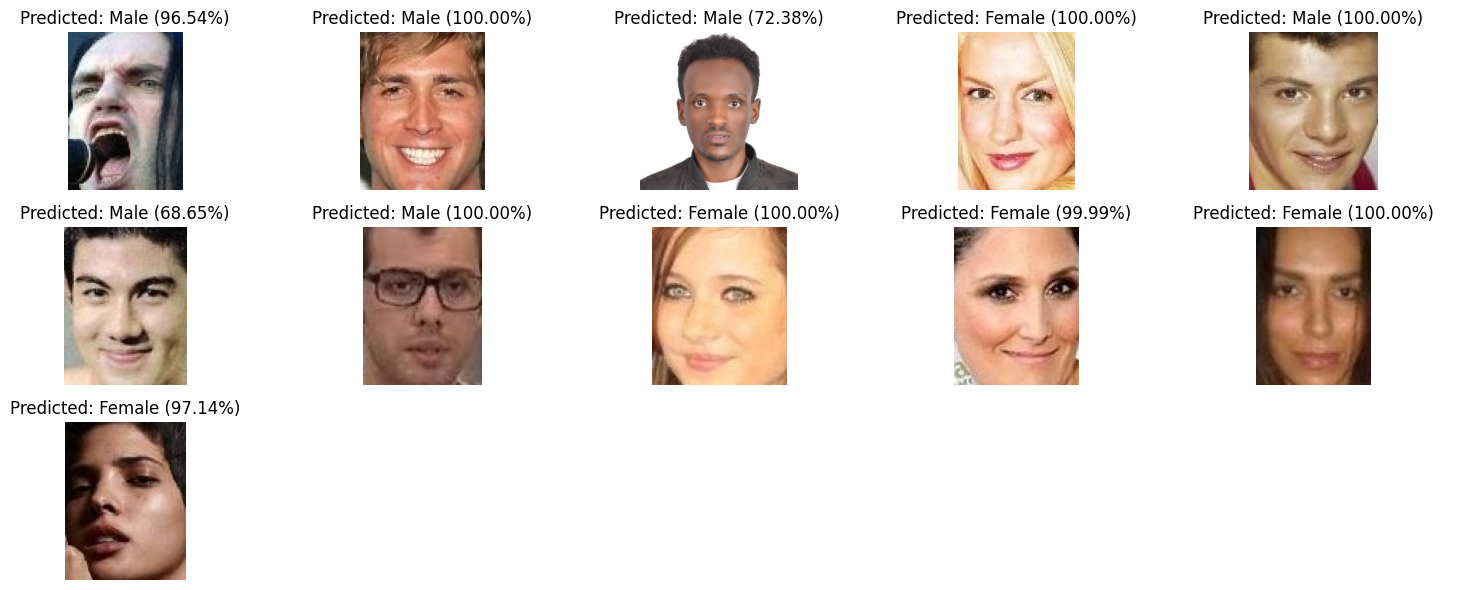

In [32]:
# Determine the number of images in the directory
num_images = len([image_name for image_name in os.listdir(image_dir) if image_name.endswith('.jpg')])

# Create subplots based on the number of images
num_rows = (num_images + 4) // 5  # Calculate the number of rows needed
fig, axs = plt.subplots(num_rows, 5, figsize=(15, 6))
axs = axs.ravel()

# Iterate over the images in the directory
for i, image_name in enumerate(os.listdir(image_dir)):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(image_dir, image_name)
        img, img_tensor = preprocess_image(image_path)

        with torch.no_grad():
            pred = model(img_tensor)
        probabilities = torch.softmax(pred, dim=1)
        predicted_label = np.argmax(probabilities)

        # Get the label (male or female) and prediction probability
        label = "Male" if predicted_label == 1 else "Female"
        probability = probabilities[0, predicted_label].item()

        # Plot the image and predicted label with probability
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].set_title(f'Predicted: {label} ({probability:.2%})')  # Include probability in title
        axs[i].axis('off')

# Hide any unused subplots
for j in range(num_images, num_rows * 5):
    axs[j].axis('off')

plt.tight_layout()
plt.show()
